In [585]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv1D, Activation, Input,Flatten,Dense, GlobalMaxPooling1D, SpatialDropout1D, Add, Reshape, LeakyReLU, BatchNormalization, Lambda, GlobalAveragePooling1D
from keras.regularizers import l2
import os
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from keras.optimizers import Adam

# Functions definition

In [586]:
def create_dataset(data, input_windows_size, labels_window_size, overlap_size):
    input_windows = []
    labels_windows = []
    instance_tokens = data['instance_token'].unique()

    for instance_token in instance_tokens:
        instance_data = data[data['instance_token'] == instance_token][:]
        # drop timestamp and instance_token columns
        instance_data = instance_data.drop(columns=['timestamp', 'instance_token'])

        # Create input windows
        for i in range(0, len(instance_data) - input_windows_size - labels_window_size + 1, input_windows_size - overlap_size):
            input_window = instance_data.iloc[i:i + input_windows_size][:].values
            label_window = instance_data.iloc[i + input_windows_size:i + input_windows_size + labels_window_size][['x_rel', 'y_rel']].values
            input_windows.append(input_window)
            labels_windows.append(label_window)

    return np.array(input_windows), np.array(labels_windows)

def create_dataset_from_dir(data_dir, input_windows_size, labels_window_size, overlap_size):
    data = pd.read_csv(os.path.join(data_dir, 'data.csv'))

    # Create dataset
    input_windows, labels_windows = create_dataset(data, input_windows_size, labels_window_size, overlap_size)
    return input_windows, labels_windows

# Dataset import

In [587]:
cwd = os.getcwd()
root_dataset = os.path.join(cwd, 'processed_data', 'v1.0-mini')
train_dir = os.path.join(root_dataset, 'train')
val_dir = os.path.join(root_dataset, 'val')
test_dir = os.path.join(root_dataset, 'test')
train_data = pd.read_csv(os.path.join(train_dir, 'data.csv'))
val_data = pd.read_csv(os.path.join(val_dir, 'data.csv'))
test_data = pd.read_csv(os.path.join(test_dir, 'data.csv'))

Dataset is split into overlapping windows of 6 elements, with a label composed of the next 10 samples

In [588]:
input_windows_size = 10
labels_window_size = 6
overlap_size = 8

In [589]:
# Create datasets
x_train, y_train = create_dataset_from_dir(train_dir, input_windows_size, labels_window_size, overlap_size)
x_val, y_val = create_dataset_from_dir(val_dir, input_windows_size, labels_window_size, overlap_size)
x_test, y_test = create_dataset_from_dir(test_dir, input_windows_size, labels_window_size, overlap_size) 

print(f"Train data shape: {x_train.shape}, {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, {y_val.shape}")
print(f"Test data shape: {x_test.shape}, {y_test.shape}")

Train data shape: (2161, 10, 6), (2161, 6, 2)
Validation data shape: (460, 10, 6), (460, 6, 2)
Test data shape: (464, 10, 6), (464, 6, 2)


# Model Definition

In [590]:
from tcn import TCN

def create_tcn_seq2seq_model(input_shape,
                             num_filters=64,
                             kernel_size=3,
                             num_dilations=3,
                             dropout_rate=0.1,
                             output_timesteps=6,
                             output_features=2,
                             alpha=0.1):
    """
    Build a seq2seq forecaster using the keras-tcn library’s TCN layer.
    
    - input_shape: (history_length, num_input_features)
    - TCN layer returns the last hidden state (return_sequences=False).
    - A Dense+Reshape head produces exactly (output_timesteps, output_features).
    """
    inputs = Input(shape=input_shape)   # e.g. (6, 5)
    
    # TCN encoder: returns a single vector summarizing the 6-step history
    #   -- nb_filters: number of convolutional filters
    #   -- kernel_size: width of the conv kernels
    #   -- dilations: dilation factors for each residual block
    #   -- dropout_rate: spatial dropout between conv layers
    #   -- return_sequences=False to grab only the final step
    tcn_out = TCN(
        nb_filters=num_filters,
        kernel_size=kernel_size,
        dilations=[2 ** i for i in range(num_dilations)],
        dropout_rate=dropout_rate,
        return_sequences=True,
        kernel_initializer='he_normal',
        activation='linear',
        use_batch_norm=True,
    )(inputs)
    
    # Dense → reshape into the desired future horizon
    x = GlobalAveragePooling1D()(tcn_out)  # summarizing while keeping temporal richness
    x = Dense(128, activation='relu')(x)
    # x = keras.layers.BatchNormalization()(x)
    x = Dense(output_timesteps * output_features, name='fc_future')(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = Reshape((output_timesteps, output_features), name='reshape_future')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='tcn_seq2seq_keras_tcn')
    return model


# Training

In [591]:
input_shape = x_train.shape[1:]
dropout_rate = 0.05
use_skip_connections = True
output_model_dir = os.path.join(cwd, 'output_model')
if not os.path.exists(output_model_dir):
    os.makedirs(output_model_dir)

In [592]:
model = create_tcn_seq2seq_model(input_shape, dropout_rate=dropout_rate, output_timesteps=labels_window_size, output_features=2)
model.summary()

Model: "tcn_seq2seq_keras_tcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 10, 6)]           0         
                                                                 
 tcn_24 (TCN)                (None, 10, 64)            64960     
                                                                 
 global_average_pooling1d_24  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 fc_future (Dense)           (None, 12)                1548      
                                                                 
 batch_normalization_26 (Bat  (None, 12)               48        
 chNormalization)                            

In [593]:
save_path = output_model_dir + "\model_trained" + ".tf"
callbacks = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="mae",
    metrics=["mae"]
)

In [594]:
history = model.fit(
    x_train,y_train,
    epochs=5000,
    validation_data=(x_val,y_val),
    batch_size=256,   
    callbacks=callbacks
)

Epoch 1/5000
9/9 [==============================] - 3s 73ms/step - loss: 0.9416 - mae: 0.9416 - val_loss: 1.7563 - val_mae: 1.7563
Epoch 2/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.8207 - mae: 0.8207 - val_loss: 1.4258 - val_mae: 1.4258
Epoch 3/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.7182 - mae: 0.7182 - val_loss: 1.2239 - val_mae: 1.2239
Epoch 4/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.6316 - mae: 0.6316 - val_loss: 1.0823 - val_mae: 1.0823
Epoch 5/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.5695 - mae: 0.5695 - val_loss: 0.9639 - val_mae: 0.9639
Epoch 6/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.5262 - mae: 0.5262 - val_loss: 0.8717 - val_mae: 0.8717
Epoch 7/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.4985 - mae: 0.4985 - val_loss: 0.8031 - val_mae: 0.8031
Epoch 8/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.4707 - m

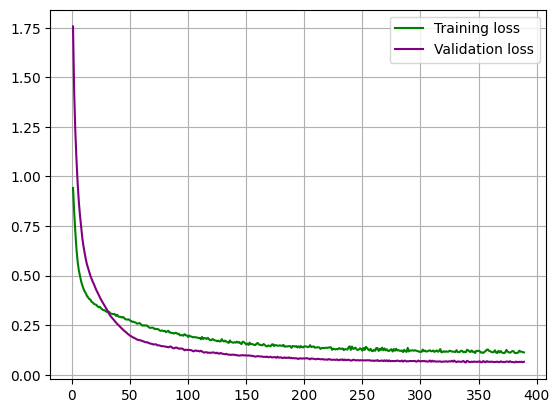

In [595]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
#loss
plt.plot(epochs,loss,"g",label="Training loss")
plt.plot(epochs,val_loss,"purple",label="Validation loss")
plt.xlabel="Epoch"
plt.ylabel="loss"
plt.title="Training and validation loss"
plt.legend(loc="best")
plt.grid()
plt.show()


In [596]:
#evaluation
output_model_dir = os.path.join(cwd, 'output_model')
model.save(output_model_dir + "\model_trained" + ".h5")
model.evaluate(x_test, y_test, verbose=1)

15/15 [==============================] - 0s 7ms/step - loss: 7.6231 - mae: 7.6231


[7.623133182525635, 7.623132228851318]

(1, 10, 6)
1/1 [==============================] - 0s 16ms/step


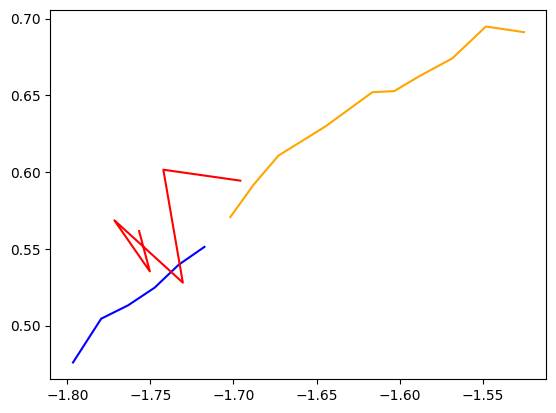

In [ ]:
idx= np.random.randint(0, len(x_test), 1)[0]
x = x_test[idx]  # Use the first sample from the test set
y = y_test[idx]  # Corresponding true labels
x = np.expand_dims(x, axis=0)  # Add batch dimension
print(x.shape)
y_pred = model.predict(x)
plt.plot(x[0, :, 0], x[0, :, 1], label='Input', color='orange')
plt.plot(y[:, 0], y[:, 1], label='True', color='blue')
plt.plot(y_pred[0, :, 0], y_pred[0, :, 1], label='Predicted', color='red')

plt.show()
